In [1]:
# Verificar entorno
import sys
print("Python version:", sys.version)

# Importar librerías esenciales
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os

print("TensorFlow version:", tf.__version__)
print("GPU disponible:", tf.config.list_physical_devices('GPU'))

Python version: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
TensorFlow version: 2.19.0
GPU disponible: []


In [2]:
# Descargar e importar el dataset
import tensorflow_datasets as tfds

# Cargar el dataset (se descargará automáticamente si no está en cache)
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# Información del dataset
num_classes = ds_info.features['label'].num_classes
class_names = ds_info.features['label'].names
print(f"Número de clases: {num_classes}")
print(f"Nombres de clases: {class_names}")

# Tamaño del dataset
print(f"Entrenamiento: {len(ds_train)} imágenes")
print(f"Validación: {len(ds_val)} imágenes")
print(f"Prueba: {len(ds_test)} imágenes")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.H7A22C_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
Número de clases: 5
Nombres de clases: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
Entrenamiento: 2569 imágenes
Validación: 551 imágenes
Prueba: 550 imágenes


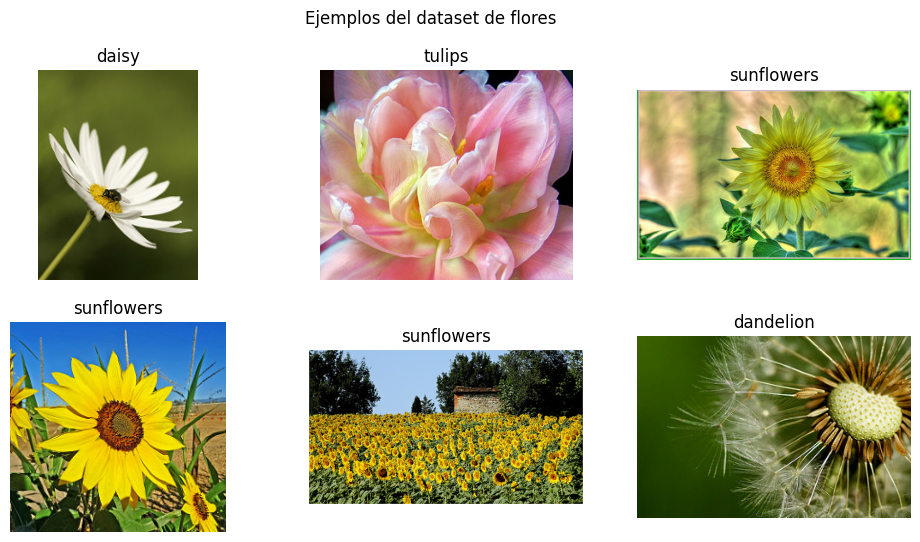

In [3]:
plt.figure(figsize=(12, 6))
for i, (image, label) in enumerate(ds_train.take(6)):
    plt.subplot(2, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(class_names[label])
    plt.axis("off")
plt.suptitle("Ejemplos del dataset de flores")
plt.show()

In [4]:
# Tamaño de entrada para EfficientNetB0
IMG_SIZE = 224
BATCH_SIZE = 32

# Función de preprocesamiento
def preprocess_image(image, label):
    # Redimensionar imagen
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    # Convertir a float32
    image = tf.cast(image, tf.float32)
    # No normalizamos aquí porque EfficientNet incluye su propio preprocesamiento
    return image, label

# Aplicar preprocesamiento y crear lotes
ds_train = ds_train.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Configurar rendimiento
ds_train = ds_train.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [5]:
# Cargar EfficientNetB0 sin la capa final (include_top=False)
base_model = keras.applications.EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Congelar las capas del modelo base
base_model.trainable = False

# Construir el modelo completo
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')  # 5 clases
])

# Compilar el modelo
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Mostrar resumen del modelo
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,184 (16.08 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [6]:
# Callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Entrenamiento
EPOCHS = 15
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

Epoch 1/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.7015 - loss: 0.8059 - val_accuracy: 0.9129 - val_loss: 0.2556
Epoch 2/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 242s 3s/step - accuracy: 0.9082 - loss: 0.2630 - val_accuracy: 0.9183 - val_loss: 0.2175
Epoch 3/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 225s 3s/step - accuracy: 0.9444 - loss: 0.1914 - val_accuracy: 0.9347 - val_loss: 0.1998
Epoch 4/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 276s 3s/step - accuracy: 0.9510 - loss: 0.1474 - val_accuracy: 0.9220 - val_loss: 0.2101
Epoch 5/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 233s 3s/step - accuracy: 0.9710 - loss: 0.1100 - val_accuracy: 0.9274 - val_loss: 0.1896
Epoch 6/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 228s 3s/step - accuracy: 0.9579 - loss: 0.1224 - val_accuracy: 0.9328 - val_loss: 0.1853
Epoch 7/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 227s 3s/step - accuracy: 0.9686 - loss: 0.0926 - val_accuracy: 0.9238 - val_loss: 0.1876
Epoch 8/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.9747 - loss: 0.0702 - val_accuracy: 0.9238 - v

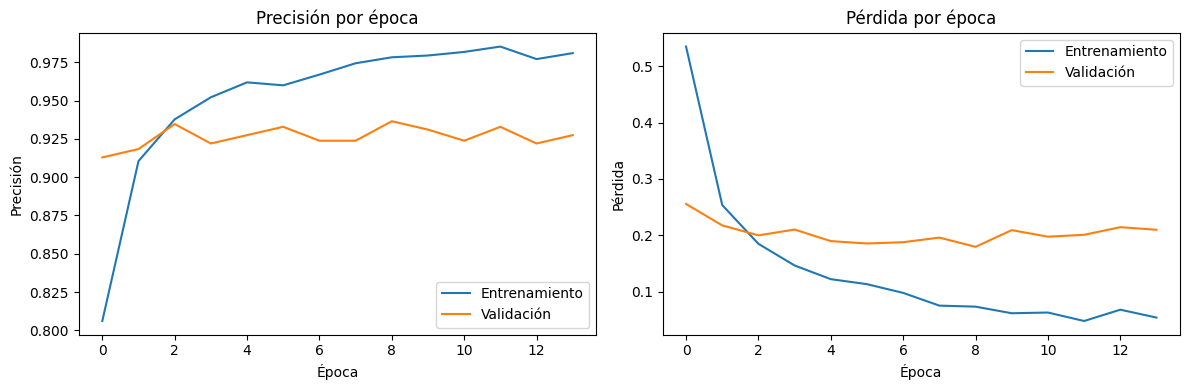

In [7]:
# Extraer métricas
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entrenamiento')
plt.plot(epochs_range, val_acc, label='Validación')
plt.legend(loc='lower right')
plt.title('Precisión por época')
plt.xlabel('Época')
plt.ylabel('Precisión')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Entrenamiento')
plt.plot(epochs_range, val_loss, label='Validación')
plt.legend(loc='upper right')
plt.title('Pérdida por época')
plt.xlabel('Época')
plt.ylabel('Pérdida')

plt.tight_layout()
plt.show()

In [8]:
test_loss, test_accuracy = model.evaluate(ds_test, verbose=0)
print(f"\n🔍 Precisión en prueba: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")


🔍 Precisión en prueba: 0.9455 (94.55%)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


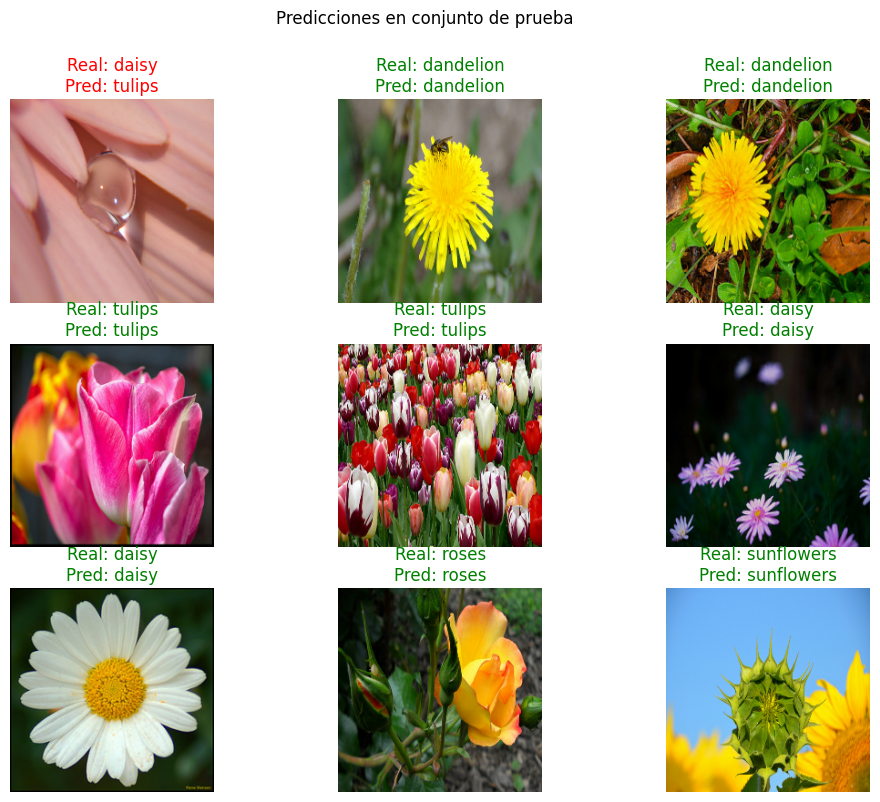

In [9]:
# Obtener un lote de prueba
images, labels = next(iter(ds_test))
predictions = model.predict(images)
predicted_classes = np.argmax(predictions, axis=1)

# Mostrar 9 predicciones
plt.figure(figsize=(12, 9))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    true_label = class_names[labels[i]]
    pred_label = class_names[predicted_classes[i]]
    color = 'green' if true_label == pred_label else 'red'
    plt.title(f"Real: {true_label}\nPred: {pred_label}", color=color)
    plt.axis("off")
plt.suptitle("Predicciones en conjunto de prueba")
plt.show()

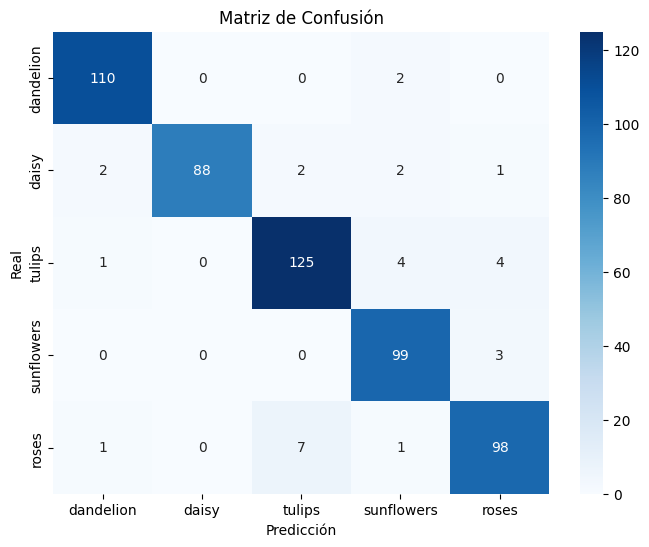


📋 Reporte de clasificación:
              precision    recall  f1-score   support

   dandelion       0.96      0.98      0.97       112
       daisy       1.00      0.93      0.96        95
      tulips       0.93      0.93      0.93       134
  sunflowers       0.92      0.97      0.94       102
       roses       0.92      0.92      0.92       107

    accuracy                           0.95       550
   macro avg       0.95      0.95      0.95       550
weighted avg       0.95      0.95      0.95       550



In [10]:
# Obtener todas las etiquetas y predicciones del conjunto de prueba
y_true = []
y_pred = []

for images, labels in ds_test:
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

# Calcular matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Reporte de clasificación
print("\n📋 Reporte de clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names))

In [11]:

analisis = """
✅ ¿Por qué se eligió EfficientNetB0?
- EfficientNetB0 ofrece un excelente equilibrio entre precisión y eficiencia computacional.
- Tiene menos parámetros que ResNet50, lo que reduce el riesgo de sobreajuste en datasets pequeños como tf_flowers (~3.6k imágenes).
- Está preentrenado en ImageNet, lo que permite transferir conocimiento visual relevante incluso con pocos datos.

⚠️ ¿Cuáles fueron los principales desafíos?
1. **Desbalance de clases**: Algunas flores (como girasoles) tienen muchas más imágenes que otras (como tulipanes), lo que puede sesgar el modelo.
2. **Variabilidad visual**: Las imágenes tienen fondos no controlados, iluminación variable y ángulos diversos.
3. **Tamaño limitado del dataset**: Con solo unas pocas miles de imágenes, el modelo puede tener dificultades para generalizar a flores no vistas.

🚀 ¿Qué mejorarías para producción?
- **Aumento de datos**: Aplicar transformaciones (rotación, zoom, volteo) para enriquecer el conjunto de entrenamiento.
- **Fine-tuning**: Descongelar las últimas capas de EfficientNetB0 y reentrenar con una tasa de aprendizaje baja (ej. 1e-5).
- **Balanceo de clases**: Usar `class_weight='balanced'` en `model.fit()` o técnicas de sobremuestreo.
- **Validación más robusta**: Implementar validación cruzada estratificada.
- **Exportación para dispositivos**: Convertir el modelo a TensorFlow Lite para uso en móviles o edge devices.
- **Monitoreo en producción**: Registrar métricas de inferencia y reentrenar periódicamente con nuevos datos.
"""

print(analisis)


✅ ¿Por qué se eligió EfficientNetB0?
- EfficientNetB0 ofrece un excelente equilibrio entre precisión y eficiencia computacional.
- Tiene menos parámetros que ResNet50, lo que reduce el riesgo de sobreajuste en datasets pequeños como tf_flowers (~3.6k imágenes).
- Está preentrenado en ImageNet, lo que permite transferir conocimiento visual relevante incluso con pocos datos.

⚠️ ¿Cuáles fueron los principales desafíos?
1. **Desbalance de clases**: Algunas flores (como girasoles) tienen muchas más imágenes que otras (como tulipanes), lo que puede sesgar el modelo.
2. **Variabilidad visual**: Las imágenes tienen fondos no controlados, iluminación variable y ángulos diversos.
3. **Tamaño limitado del dataset**: Con solo unas pocas miles de imágenes, el modelo puede tener dificultades para generalizar a flores no vistas.

🚀 ¿Qué mejorarías para producción?
- **Aumento de datos**: Aplicar transformaciones (rotación, zoom, volteo) para enriquecer el conjunto de entrenamiento.
- **Fine-tuning*

In [12]:
# Guardar el modelo entrenado
model.save("efficientnet_flowers.h5")
print("✅ Modelo guardado como 'efficientnet_flowers.h5'")

✅ Modelo guardado como 'efficientnet_flowers.h5'
